# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier,  RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
import gensim
import pandas as pd
import numpy as np
from pymorphy2 import MorphAnalyzer
import pyLDAvis.gensim_models
from collections import Counter
from string import punctuation
from razdel import tokenize as razdel_tokenize
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from matplotlib import pyplot as plt
import seaborn as sns
morph = MorphAnalyzer()

C:\Users\posch\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\posch\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\posch\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\posch\AppData\Local\Programs\Python\Python310\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.g

In [3]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word \
                                                            in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word and len(word) < 20 ]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    return ' '.join(normalized_text)

In [4]:
data = pd.read_csv('avito_category_classification.csv')

In [5]:
data

,category_name,description
0,Автомобили,"отличное состояние,обслужиание в салоне"
1,Детская одежда и обувь,В отличном состоянии. Фирма KIKO. Очень теплый...
2,Предложение услуг,"Изготовление ограждений, перил,качелей, турник..."
3,Автомобили,Автомобиль в отличном техническом состоянии. О...
4,Бытовая техника,"Продается газовая плита ""Гефест"" (Белоруссия) ..."
...,...,...
9893,Товары для детей и игрушки,Чтобы посмотреть весь ассортимент нашего магаз...
9894,Детская одежда и обувь,"Весна,осень.74-80.вопросы можно в вайбер,двухс..."
9895,"Одежда, обувь, аксессуары","Кимоно Green Hill. Состояние отличное, рост ..."
9896,Детская одежда и обувь,Б/у кроссовки на девочку. Носили только в спор...


In [6]:
data['description_norm'] = data['description'].apply(normalize)

In [7]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), min_df=5, max_df=0.1)
svd = TruncatedSVD(500)

# RandomForestClassifier

In [8]:
pipeline_svd_randomforest = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=10))
])

pipeline_nmf_randomforest = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])


In [9]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [14]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_randomforest)

In [15]:
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.88,0.02,0.90,0.03,0.89,0.01
Бытовая техника,0.79,0.25,0.07,0.05,0.13,0.08
Мебель и интерьер,0.91,0.16,0.04,0.02,0.07,0.03
Телефоны,0.93,0.04,0.38,0.05,0.54,0.05
Предложение услуг,0.74,0.06,0.47,0.04,0.57,0.03
"Одежда, обувь, аксессуары",0.47,0.02,0.76,0.02,0.58,0.01
Детская одежда и обувь,0.46,0.02,0.69,0.03,0.55,0.02
Автомобили,0.85,0.08,0.60,0.05,0.70,0.06
Товары для детей и игрушки,0.85,0.05,0.19,0.06,0.31,0.09
Ремонт и строительство,0.76,0.15,0.08,0.03,0.15,0.06


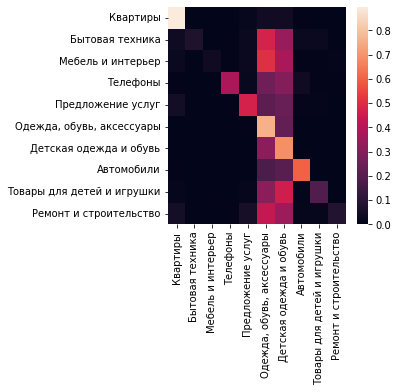

In [16]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [10]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_randomforest)

In [11]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.88,0.03,0.95,0.03,0.91,0.02
Бытовая техника,1.00,0.00,0.03,0.01,0.05,0.02
Мебель и интерьер,0.77,0.09,0.10,0.07,0.17,0.10
Телефоны,0.93,0.03,0.38,0.05,0.54,0.04
Предложение услуг,0.67,0.07,0.48,0.05,0.56,0.06
"Одежда, обувь, аксессуары",0.46,0.04,0.81,0.05,0.58,0.02
Детская одежда и обувь,0.62,0.07,0.71,0.05,0.66,0.03
Автомобили,0.89,0.03,0.76,0.05,0.82,0.03
Товары для детей и игрушки,0.86,0.04,0.36,0.07,0.50,0.07
Ремонт и строительство,0.79,0.21,0.04,0.02,0.08,0.04


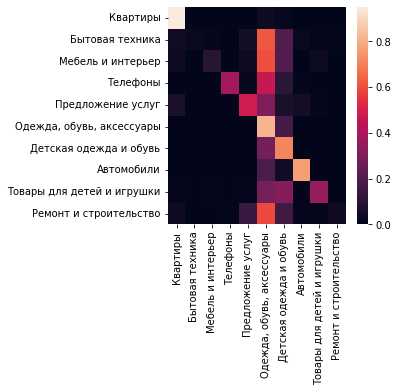

In [12]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_nmf.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [17]:
metrics_svd - metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.00,-0.01,-0.05,0.00,-0.02,-0.01
Бытовая техника,-0.21,0.25,0.04,0.04,0.08,0.06
Мебель и интерьер,0.14,0.07,-0.06,-0.05,-0.10,-0.07
Телефоны,0.00,0.01,0.00,0.00,0.00,0.01
Предложение услуг,0.07,-0.01,-0.01,-0.01,0.01,-0.03
"Одежда, обувь, аксессуары",0.01,-0.02,-0.05,-0.03,0.00,-0.01
Детская одежда и обувь,-0.16,-0.05,-0.02,-0.02,-0.11,-0.01
Автомобили,-0.04,0.05,-0.16,0.00,-0.12,0.03
Товары для детей и игрушки,-0.01,0.01,-0.17,-0.01,-0.19,0.02
Ремонт и строительство,-0.03,-0.06,0.04,0.01,0.07,0.02


# ExtraTreesClassifier

In [18]:
pipeline_svd_extratrees = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', ExtraTreesClassifier(n_estimators=100, max_depth=10))
])

pipeline_nmf_extratrees = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

In [19]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [20]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_extratrees)


In [21]:
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.64,0.04,0.52,0.05,0.57,0.04
Бытовая техника,0.90,0.17,0.05,0.02,0.09,0.04
Мебель и интерьер,0.78,0.40,0.02,0.01,0.04,0.03
Телефоны,1.00,0.00,0.10,0.04,0.17,0.06
Предложение услуг,0.61,0.49,0.01,0.01,0.03,0.03
"Одежда, обувь, аксессуары",0.37,0.01,0.82,0.02,0.51,0.01
Детская одежда и обувь,0.40,0.01,0.60,0.02,0.48,0.01
Автомобили,0.95,0.04,0.12,0.02,0.21,0.03
Товары для детей и игрушки,0.86,0.12,0.06,0.02,0.10,0.04
Ремонт и строительство,0.78,0.39,0.05,0.04,0.10,0.07


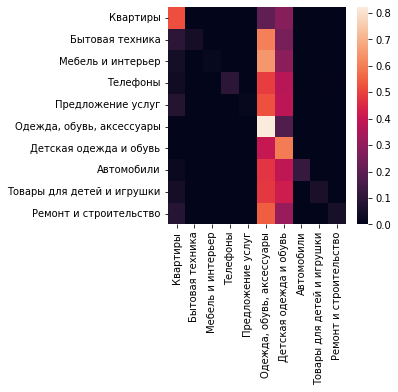

In [22]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF 

In [23]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_randomforest)

In [24]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.87,0.03,0.95,0.02,0.91,0.02
Бытовая техника,0.50,0.55,0.02,0.03,0.04,0.06
Мебель и интерьер,0.86,0.10,0.15,0.10,0.24,0.14
Телефоны,0.94,0.06,0.25,0.14,0.38,0.16
Предложение услуг,0.72,0.06,0.48,0.06,0.57,0.03
"Одежда, обувь, аксессуары",0.43,0.02,0.83,0.05,0.57,0.02
Детская одежда и обувь,0.64,0.06,0.69,0.02,0.66,0.03
Автомобили,0.86,0.06,0.79,0.06,0.82,0.04
Товары для детей и игрушки,0.86,0.06,0.33,0.04,0.48,0.04
Ремонт и строительство,0.83,0.22,0.05,0.03,0.09,0.05


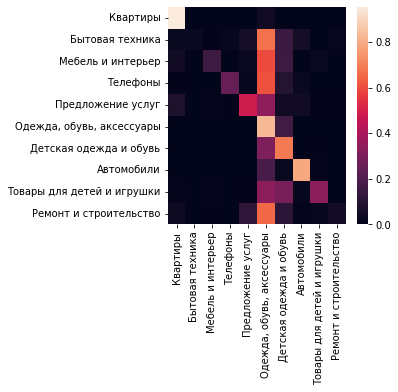

In [25]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [26]:
metrics_svd - metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,-0.23,0.01,-0.43,0.03,-0.34,0.02
Бытовая техника,0.40,-0.38,0.03,-0.01,0.05,-0.02
Мебель и интерьер,-0.08,0.30,-0.13,-0.09,-0.20,-0.11
Телефоны,0.06,-0.06,-0.15,-0.10,-0.21,-0.10
Предложение услуг,-0.11,0.43,-0.47,-0.05,-0.54,0.00
"Одежда, обувь, аксессуары",-0.06,-0.01,-0.01,-0.03,-0.06,-0.01
Детская одежда и обувь,-0.24,-0.05,-0.09,0.00,-0.18,-0.02
Автомобили,0.09,-0.02,-0.67,-0.04,-0.61,-0.01
Товары для детей и игрушки,0.00,0.06,-0.27,-0.02,-0.38,0.00
Ремонт и строительство,-0.05,0.17,0.00,0.01,0.01,0.02


# SGDClassifier

In [27]:
pipeline_svd_SGD = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', SGDClassifier())
])

pipeline_nmf_SGD = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])



In [28]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [29]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_SGD)

In [30]:
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.97,0.02,0.96,0.02,0.96,0.01
Бытовая техника,0.62,0.07,0.49,0.06,0.54,0.05
Мебель и интерьер,0.71,0.05,0.61,0.04,0.66,0.03
Телефоны,0.81,0.05,0.81,0.07,0.81,0.04
Предложение услуг,0.78,0.06,0.75,0.04,0.77,0.01
"Одежда, обувь, аксессуары",0.68,0.03,0.81,0.03,0.74,0.01
Детская одежда и обувь,0.76,0.03,0.74,0.03,0.75,0.01
Автомобили,0.87,0.02,0.89,0.03,0.88,0.02
Товары для детей и игрушки,0.73,0.05,0.64,0.04,0.68,0.03
Ремонт и строительство,0.61,0.04,0.47,0.06,0.53,0.05


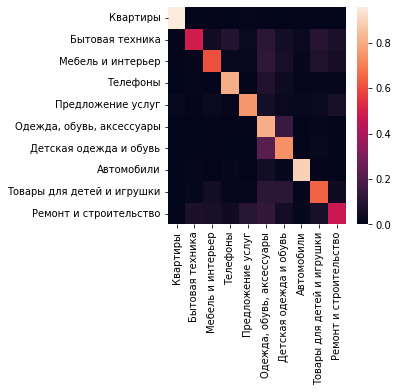

In [31]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [32]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_SGD)

In [33]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.88,0.04,0.95,0.01,0.91,0.03
Бытовая техника,0.58,0.49,0.02,0.02,0.04,0.04
Мебель и интерьер,0.81,0.12,0.14,0.06,0.24,0.08
Телефоны,0.89,0.08,0.33,0.09,0.47,0.10
Предложение услуг,0.71,0.08,0.49,0.04,0.57,0.04
"Одежда, обувь, аксессуары",0.44,0.01,0.85,0.01,0.58,0.01
Детская одежда и обувь,0.65,0.01,0.69,0.02,0.67,0.02
Автомобили,0.87,0.06,0.80,0.07,0.83,0.04
Товары для детей и игрушки,0.85,0.06,0.32,0.04,0.46,0.05
Ремонт и строительство,0.83,0.12,0.06,0.03,0.12,0.06


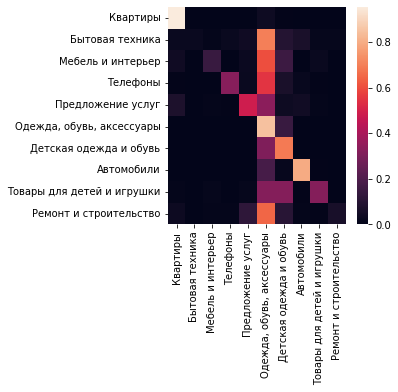

In [34]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [35]:
metrics_svd - metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.09,-0.02,0.01,0.01,0.05,-0.02
Бытовая техника,0.04,-0.42,0.47,0.04,0.50,0.01
Мебель и интерьер,-0.10,-0.07,0.47,-0.02,0.42,-0.05
Телефоны,-0.08,-0.03,0.48,-0.02,0.34,-0.06
Предложение услуг,0.07,-0.02,0.26,0.00,0.20,-0.03
"Одежда, обувь, аксессуары",0.24,0.02,-0.04,0.02,0.16,0.00
Детская одежда и обувь,0.11,0.02,0.05,0.01,0.08,-0.01
Автомобили,0.00,-0.04,0.09,-0.04,0.05,-0.02
Товары для детей и игрушки,-0.12,-0.01,0.32,0.00,0.22,-0.02
Ремонт и строительство,-0.22,-0.08,0.41,0.03,0.41,-0.01


## KNeighborsClassifier

In [36]:
pipeline_svd_kneighbours = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), ngram_range=(1,2), min_df=5, max_df=0.4)),
    ('svd', TruncatedSVD(500)),
    ('clf', KNeighborsClassifier())
])

pipeline_nmf_kneighbours = Pipeline([
    ('bow', CountVectorizer(tokenizer=lambda x: x.split(), min_df=3, max_df=0.3)),
    ('tfidf', TfidfTransformer()),
    ('decomposition', NMF(100)),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=6))
])

In [37]:
def eval_table(X, y, pipeline, N=6):
    
    labels = list(set(y))
    fold_metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))
    kfold = StratifiedKFold(n_splits=N, shuffle=True, )
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        
        fold_metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        fold_metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')

    result = pd.DataFrame(index=labels)
    result['precision'] = fold_metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = fold_metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['recall'] = fold_metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = fold_metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result['f1'] = fold_metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = fold_metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)

    result.loc['mean'] = result.mean().round(2)
    
    errors /= N
    
    return result, errors

## SVD

In [38]:
metrics_svd, errors_svd = eval_table(data['description_norm'], data['category_name'], pipeline_svd_kneighbours)

In [39]:
metrics_svd

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.94,0.03,0.72,0.04,0.82,0.03
Бытовая техника,0.26,0.06,0.26,0.06,0.26,0.06
Мебель и интерьер,0.34,0.03,0.26,0.03,0.29,0.03
Телефоны,0.70,0.12,0.30,0.05,0.42,0.06
Предложение услуг,0.60,0.03,0.56,0.03,0.58,0.03
"Одежда, обувь, аксессуары",0.47,0.02,0.59,0.01,0.53,0.01
Детская одежда и обувь,0.48,0.02,0.62,0.04,0.54,0.02
Автомобили,0.57,0.06,0.59,0.03,0.58,0.04
Товары для детей и игрушки,0.52,0.10,0.25,0.05,0.33,0.06
Ремонт и строительство,0.28,0.05,0.17,0.02,0.21,0.02


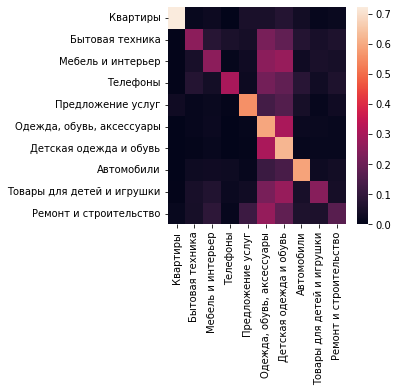

In [40]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_svd, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_svd.index.tolist()[:-1])
plt.show()

## NMF

In [42]:
metrics_nmf, errors_nmf = eval_table(data['description_norm'], data['category_name'], pipeline_nmf_kneighbours)

In [43]:
metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.88,0.06,0.95,0.03,0.91,0.03
Бытовая техника,0.67,0.52,0.02,0.02,0.04,0.04
Мебель и интерьер,0.75,0.09,0.14,0.05,0.24,0.06
Телефоны,0.97,0.03,0.24,0.13,0.37,0.16
Предложение услуг,0.69,0.09,0.45,0.07,0.54,0.06
"Одежда, обувь, аксессуары",0.43,0.02,0.84,0.03,0.57,0.02
Детская одежда и обувь,0.65,0.03,0.69,0.04,0.67,0.02
Автомобили,0.87,0.04,0.76,0.05,0.81,0.02
Товары для детей и игрушки,0.85,0.05,0.35,0.02,0.49,0.02
Ремонт и строительство,0.64,0.12,0.06,0.03,0.11,0.05


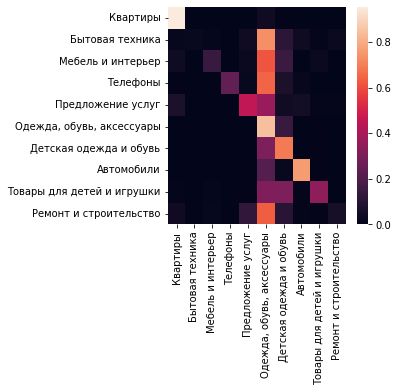

In [44]:
plt.figure(figsize=(4, 4))
sns.heatmap(errors_nmf, xticklabels=metrics_svd.index.tolist()[:-1], 
            yticklabels=metrics_nmf.index.tolist()[:-1])
plt.show()

In [45]:
metrics_svd - metrics_nmf

,precision,precision_std,recall,recall_std,f1,f1_std
Квартиры,0.06,-0.03,-0.23,0.01,-0.09,0.00
Бытовая техника,-0.41,-0.46,0.24,0.04,0.22,0.02
Мебель и интерьер,-0.41,-0.06,0.12,-0.02,0.05,-0.03
Телефоны,-0.27,0.09,0.06,-0.08,0.05,-0.10
Предложение услуг,-0.09,-0.06,0.11,-0.04,0.04,-0.03
"Одежда, обувь, аксессуары",0.04,0.00,-0.25,-0.02,-0.04,-0.01
Детская одежда и обувь,-0.17,-0.01,-0.07,0.00,-0.13,0.00
Автомобили,-0.30,0.02,-0.17,-0.02,-0.23,0.02
Товары для детей и игрушки,-0.33,0.05,-0.10,0.03,-0.16,0.04
Ремонт и строительство,-0.36,-0.07,0.11,-0.01,0.10,-0.03


# Выводы:

По метрике precision лучшее сочетание - RandomForest + NMF. По метрике recall - SGDClassifyer + SVD. Оптимально использовать SGDClassifyer+ SVD, поскольку его precision не сильно отличается от максимального, но recall значительно выше, чем в других сочетаниях.
В среднем, любые сочетания классификатора с NMF лучше, чем аналогичные с SVD (SGDClassifyer - исключение из этой тенденции).

### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивте качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

# 1. Модель без N-грамм и tfidf

In [46]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [47]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [48]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [49]:
print(dictinary)

Dictionary<5365 unique tokens: ['1,2', '1,5', '12', '14', '16']...>


In [50]:
corpus = [dictinary.doc2bow(text.split()) for text in texts]

In [51]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 3),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 2),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 6),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 2),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 12),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 2),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 3),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1)],
 [(84, 2),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 2),
  (91, 

In [58]:
lda = gensim.models.LdaModel(corpus, 200, id2word=dictinary, passes=5)

In [59]:
model = lda(50)
LatentDirichletAllocation

TypeError: 'LdaModel' object is not callable

In [60]:
model.fit(50)

ValueError: Expected 2D array, got scalar array instead:
array=50.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
feat_names = vectorizer.get_feature_names()

In [ ]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

In [ ]:
model.reconstruction_err_

In [ ]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

In [ ]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [ ]:
coherence_model_lda.get_coherence()

# 2. Модель с N-граммами

In [ ]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 


# ! не забудьте, что далее вам нужно будет использовать ngrammed_texts

In [ ]:
dictinary = gensim.corpora.Dictionary((text.split() for text in ngrammed_texts))

In [ ]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [ ]:
print(dictinary)

In [ ]:
corpus = [dictinary.doc2bow(text.split()) for text in ngrammed_texts]

In [ ]:
corpus

In [ ]:
model = LatentDirichletAllocation(50)

In [ ]:
model.fit(X)

In [ ]:
feat_names = vectorizer.get_feature_names()

In [ ]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

In [ ]:
model.reconstruction_err_

In [ ]:
np.exp2(-lda.log_perplexity(corpus[:1000]))

In [ ]:
topics = []
for topic_id, topic in lda.show_topics(num_topics=100, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [ ]:
coherence_model_lda.get_coherence()

!! В модели с нграммами вначале посмотрите, что получается после преобразования
Если вы выведите несколько первых текстов в ngrammed_texts, то там должно быть что-то такое:

In [ ]:
[text for text in ngrammed_texts[:3]]
>> [['новостройка',
  'нижегородский_область', # нграм
  'новостро́йка',
  '—',
  'сельский',
  'посёлок',
  'в',
  'дивеевский_район', # нграм
  'нижегородский_область', #нграмм
  'входить',
  'в',
  'состав_сатисский', #нграмм
  'сельсовет',
  'посёлок',
  'расположить',
  'в',
  '12,5',
  'километр',
....

Если вы не видите нграммов, то попробуйте изменить параметр threshold

Tfidf добавляется вот так (после векторизации и перед обучением lda)

# 3. Модель с tfidf

In [ ]:
texts = open('wiki_data.txt', encoding="utf8").read().splitlines()[:3000]
texts = ([normalize(text) for text in texts])

In [ ]:
dictinary = gensim.corpora.Dictionary((text.split() for text in texts))

In [ ]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [ ]:
print(dictinary)

In [ ]:
corpus = [dictinary.doc2bow(text.split()) for text in ngrammed_texts]

In [ ]:
corpus

In [ ]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
corpus = tfidf[corpus]

In [ ]:
model = LatentDirichletAllocation(50)

In [ ]:
model.fit(X)

In [ ]:
feat_names = vectorizer.get_feature_names()

In [ ]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [ ]:
coherence_model_lda.get_coherence()

# 4. Модель с N-граммами и tfidf

In [ ]:
texts = [text.split() for text in texts]
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts] 

In [ ]:
dictinary = gensim.corpora.Dictionary((text.split() for text in ngrammed_texts))

In [ ]:
dictinary.filter_extremes(no_above=0.1, no_below=10)
dictinary.compactify()

In [ ]:
print(dictinary)

In [ ]:
corpus = [dictinary.doc2bow(text.split()) for text in ngrammed_texts]

In [ ]:
corpus

In [ ]:
tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary)
corpus = tfidf[corpus]

In [ ]:
model = LatentDirichletAllocation(50)

In [ ]:
model.fit(X)

In [ ]:
feat_names = vectorizer.get_feature_names()

In [ ]:
top_words = model.components_.argsort()[:,:-5:-1]

for i in range(top_words.shape[0]):
    words = [feat_names[j] for j in top_words[i]]
    print(i, "--".join(words))

In [ ]:
coherence_model_lda = gensim.models.CoherenceModel(topics=topics, 
                                                   texts=[text.split() for text in ngrammed_texts], 
                                                   dictionary=dictinary, coherence='c_v')

In [ ]:
coherence_model_lda.get_coherence()